# PROJECTE IDENTIFICACIÓ DE VEU PER 4 PERSONES

### Introducció

Este proyecto tiene como objetivo diseñar e implementar un sistema de reconocimiento e identificación de voz para cuatro personas específicas. El sistema utilizará técnicas de procesamiento de señales de audio y aprendizaje automático para reconocer y distinguir las voces de las personas autorizadas.
El proceso de desarrollo constará de varias etapas clave. En primer lugar, se recopilarán muestras de voz de las cuatro personas de interés, abarcando una variedad de palabras y frases relevantes para el contexto de uso previsto. Estas muestras de voz se preprocesarán para extraer características acústicas relevantes, como tono, intensidad y frecuencia.
A continuación, se utilizarán algoritmos de aprendizaje automático para entrenar un modelo de reconocimiento de voz. Durante el entrenamiento, el modelo aprenderá a asociar las características acústicas de las muestras de voz con las identidades de las cuatro personas.
Una vez entrenado el modelo, se procederá a la fase de evaluación y ajuste fino. Se probará el sistema utilizando conjuntos de datos adicionales que no se utilizaron durante el entrenamiento, con el fin de evaluar su precisión y rendimiento en la identificación de las cuatro personas. Se realizarán ajustes en el modelo según sea necesario para mejorar su capacidad de reconocimiento y reducir posibles errores.


### Datos


Recopilaremos muestras de voz de cada uno de los usuarios a identificar mediante el modelo, 50 audios del tipo "hola, qué tal?" para cada uno de los usuarios a identificar, adicionalmente añadiremos 100 muestras de audio de usuarios diferentes a identificar. Por lo tanto contaremos con un total 300 audios.

|  id |  id_mensaje | audio    |   id persona |
|-----------|-----------|-----------|-----------|
| int    (0 -> 299)     |  int (01 -> 50)  |  str (path)  |  int (0 -> 5)



### Procedimiento

A paritr de los audios generados individualmente, los convertiremos en espectogramas para así convertir audios en imágenes. Los espectogramas serán las características de cada usuario a identificar. 

#### Imports

In [1]:
from pydub import AudioSegment
import time
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fft
import numpy as np
import warnings

warnings.filterwarnings("ignore")

#### Pasar a mp3 los audios

In [2]:
#Conversion a mp3
files = os.listdir('Audios')
for file in files:
    if file[-3:] == ('m4a' or 'mp4') :
        try:
            audio = AudioSegment.from_file('Audios\\' + file, format=file[-3:])
            audio.export('AudiosMp3\\' + file[:-4] + ".mp3", format="mp3")
        except:
            audio = AudioSegment.from_file('Audios/' + file, format=file[-3:])
            audio.export('AudiosMp3/' + file[:-4] + ".mp3", format="mp3")

t0 = time.time()
audio = AudioSegment.from_file("prueba.m4a", format="m4a")
print("Tiempo de carga: ", time.time() - t0)

t0 = time.time()
audio.export("archivo.mp3", format="mp3")
print("Tiempo de conversión: ", time.time() - t0)

print("Conversión completada.")

Tiempo de carga:  0.14380359649658203
Tiempo de conversión:  0.11269307136535645
Conversión completada.


#### Creación Dataset

In [3]:
filesMp3 = os.listdir('AudiosMp3')
dict = {'Id_Mensaje': [], 'Audio': [], 'Id_Persona': []}
for file in filesMp3:
    dict['Id_Mensaje'].append(int(file[:2]))
    dict['Audio'].append(file)
    if file[3:-4] == 'Gerard': 
        dict['Id_Persona'].append(0)
    elif file[3:-4] == 'Albert': 
        dict['Id_Persona'].append(1)
    elif file[3:-4] == 'Adrian': 
        dict['Id_Persona'].append(3)
    elif file[3:-4] == 'Raul': 
        dict['Id_Persona'].append(3)
    elif file[3:-4] == 'MadreGerard':
        dict['Id_Persona'].append(2) 
    elif file[3:-4] == 'PadreGerard':
        dict['Id_Persona'].append(2)
    elif file[3:-4] == 'Jessi':
        dict['Id_Persona'].append(2)
        
df = pd.DataFrame(dict)
print(df)
    

     Id_Mensaje               Audio  Id_Persona
0             1       01_Albert.mp3           1
1             1       01_Gerard.mp3           0
2             2       02_Albert.mp3           1
3             2       02_Gerard.mp3           0
4             3       03_Albert.mp3           1
..          ...                 ...         ...
162          50       50_Albert.mp3           1
163          50       50_Gerard.mp3           0
164          50        50_Jessi.mp3           2
165          50  50_MadreGerard.mp3           2
166          50  50_PadreGerard.mp3           2

[167 rows x 3 columns]


#### Visualizar audios

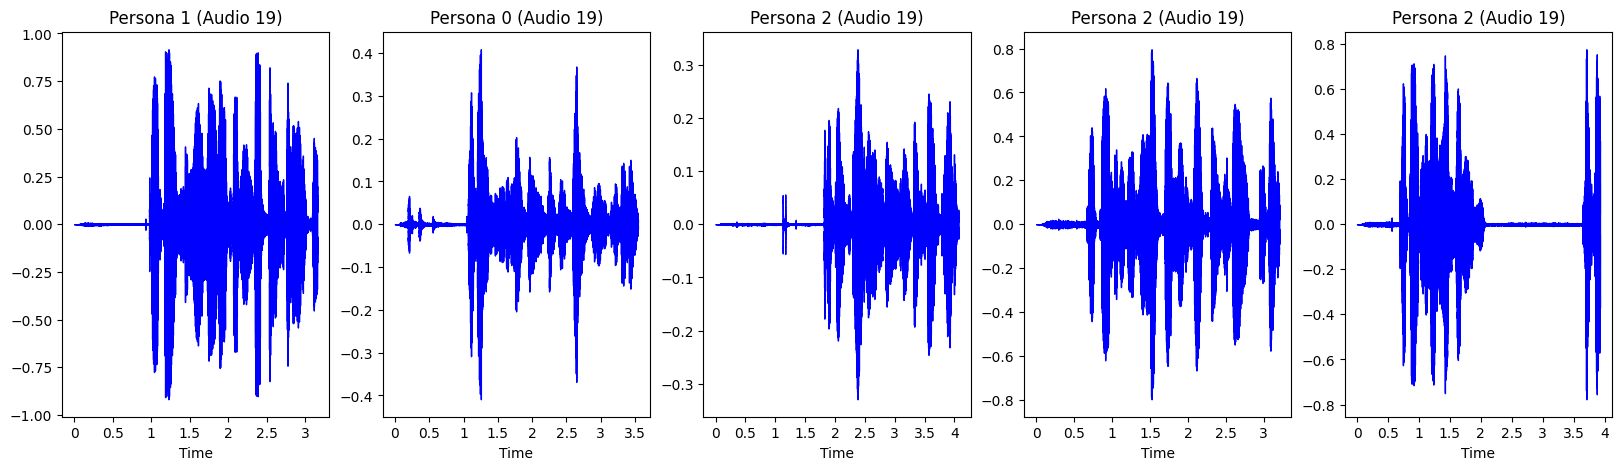

In [4]:
nAudio = 19
audios = df[df['Id_Mensaje'] == nAudio]
audios = audios.reset_index()
fig, ax = plt.subplots(1, len(audios), figsize=(20, 5))
i = 0
for index, row in audios.iterrows():
      # Cargar el archivo de audio MP3
    try:
      y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
    except:
      y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
    librosa.display.waveshow(y ,sr=sr, ax=ax[i], color="blue")
    ax[i].set_title('Persona ' + str(row['Id_Persona']) + ' (Audio ' + str(nAudio) + ')')
    i = i +1
    


In [5]:
def fft_plot(y, sr, persona, nAudio, ax):
    n = len(y)
    T = 1/sr
    yf = np.fft.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), int(n/2))
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    ax.grid()
    ax.set_title("Rang de Frequencies Persona " + str(persona) + " (Audio " + str(nAudio) +")")
    ax.set_xlabel("Frequencia")
    ax.set_ylabel("Magnitud")
    c = yf[:n//2]

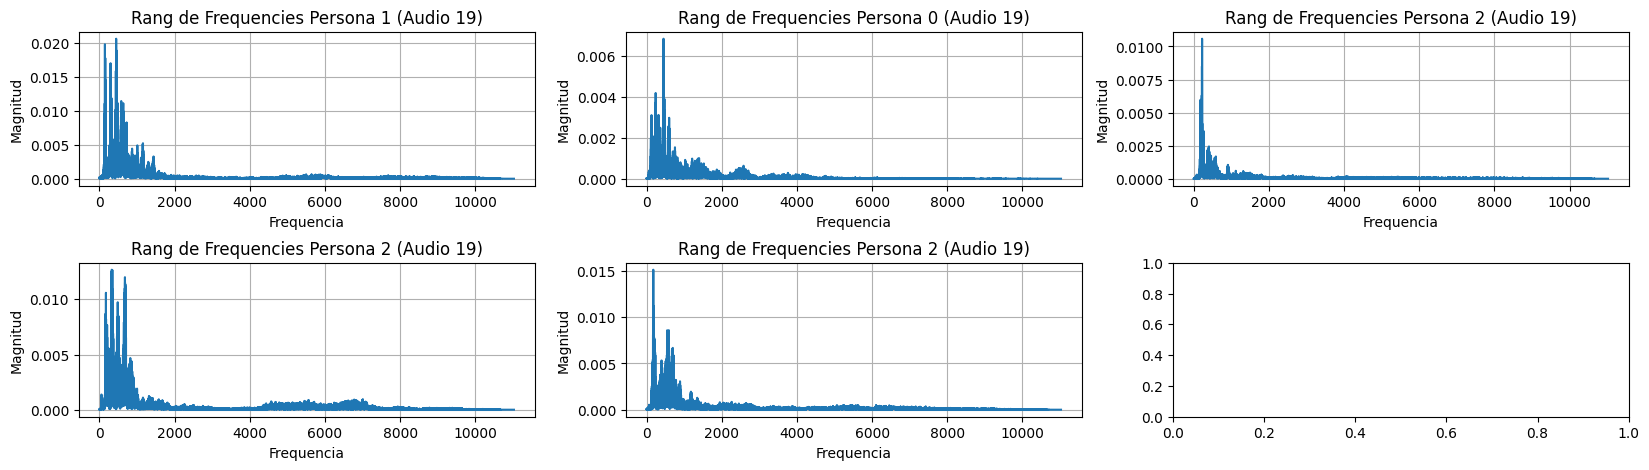

In [6]:
fig, ax = plt.subplots(2, int(len(audios)/2) + 1, figsize=(20, 5))
i = 0
j = 0
for index, row in audios.iterrows():
      # Cargar el archivo de audio MP3
    try:
      y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
    except:
      y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
    fft_plot(y, sr, row['Id_Persona'], nAudio, ax[i, j])
    j = j + 1
    if j == int(len(audios)/2) + 1:
        j = 0
        i = i + 1
plt.subplots_adjust(hspace=0.5)  # Ajustar el espacio vertical entre subgráficos
        


### Familiarització amb espectogrames

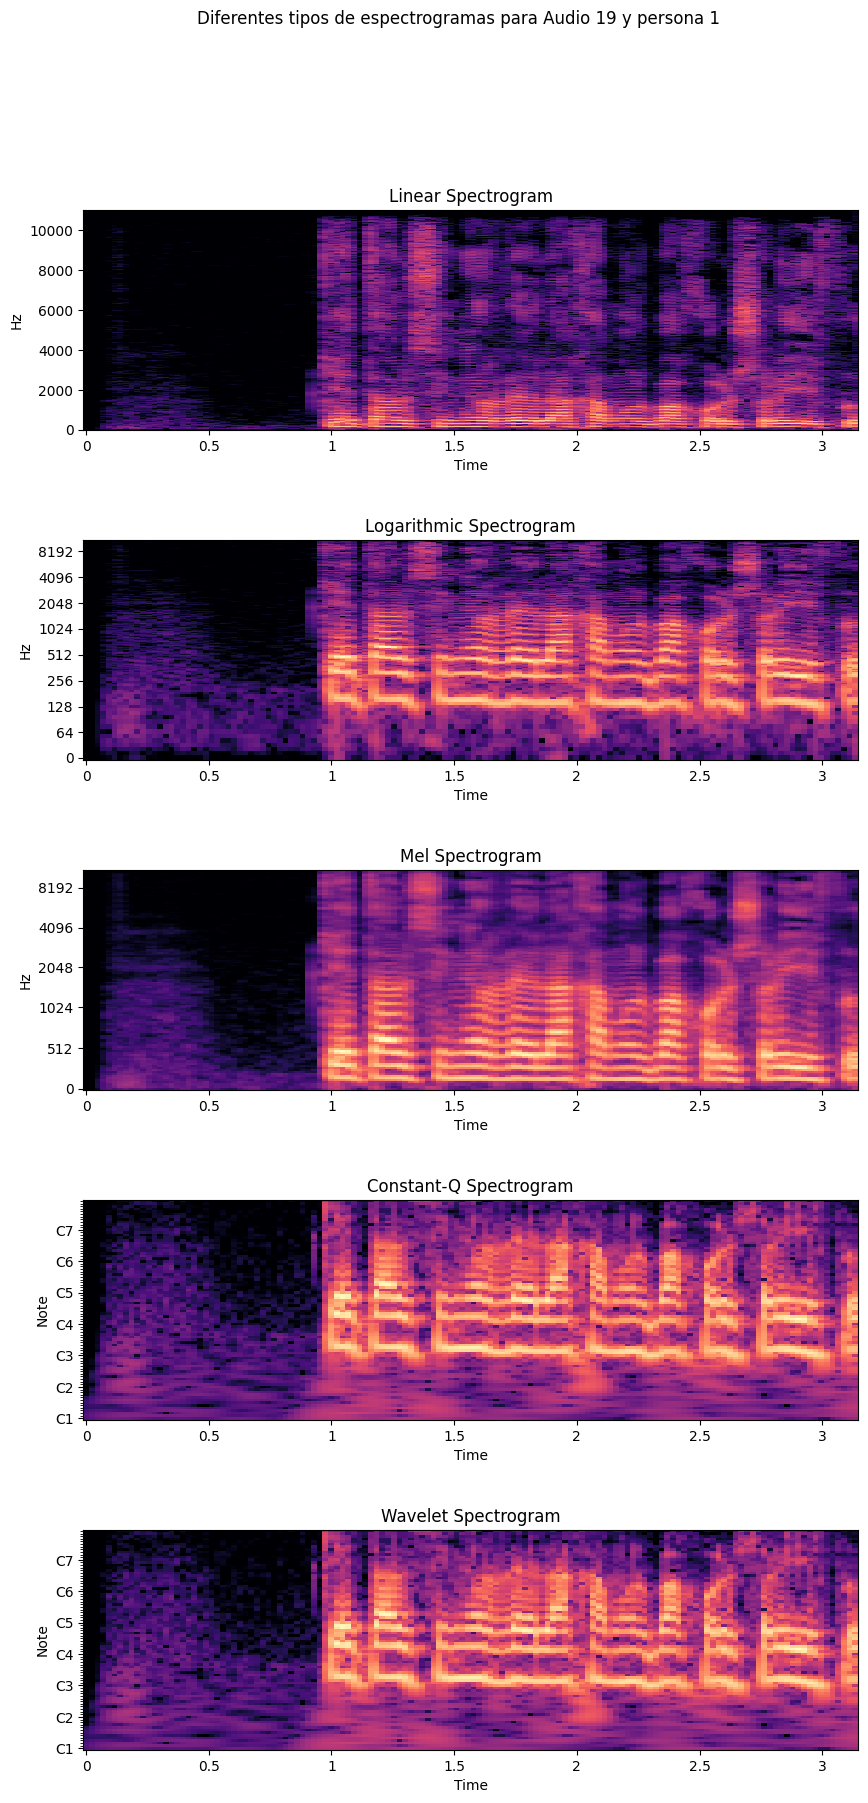

In [7]:
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

audio = audios.iloc[0]
try:
    y, sr = librosa.load(f"AudiosMp3\\{audio['Audio']}")
except:
    y, sr = librosa.load(f"AudiosMp3/{audio['Audio']}")

linear_spec = np.abs(librosa.stft(y))
librosa.display.specshow(librosa.amplitude_to_db(linear_spec, ref=np.max), ax=axs[0], sr=sr, x_axis='time', y_axis='linear')
axs[0].set_title('Linear Spectrogram')

log_spec = np.abs(librosa.stft(y))
librosa.display.specshow(librosa.amplitude_to_db(log_spec, ref=np.max), ax=axs[1], sr=sr, x_axis='time', y_axis='log')
axs[1].set_title('Logarithmic Spectrogram')

mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), ax=axs[2], sr=sr, x_axis='time', y_axis='mel')
axs[2].set_title('Mel Spectrogram')

cqt_spec = np.abs(librosa.cqt(y, sr=sr))
librosa.display.specshow(librosa.amplitude_to_db(cqt_spec, ref=np.max), ax=axs[3], sr=sr, x_axis='time', y_axis='cqt_note')
axs[3].set_title('Constant-Q Spectrogram')

wavelet_spec = np.abs(librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('C1')))
librosa.display.specshow(librosa.amplitude_to_db(wavelet_spec, ref=np.max), ax=axs[4], sr=sr, x_axis='time', y_axis='cqt_note')
axs[4].set_title('Wavelet Spectrogram')

fig.suptitle('Diferentes tipos de espectrogramas para Audio ' + str(nAudio) + ' y persona ' + str(audio['Id_Persona']))

plt.subplots_adjust(hspace=0.5)
plt.show()


### El primer model (Logistic regression amb 7 característiques extretes de librosa.feature)

In [8]:
def extract_features(y, sr):
    features = []
    features.append(np.mean(librosa.feature.chroma_stft(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.zero_crossing_rate(y)))
    features.append(np.mean(librosa.feature.spectral_flatness(y=y)))
    features.append(np.mean(librosa.feature.rms(y=y)))
    return features


In [9]:
def compute_row(row):
    try:
        y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
    except:
        y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
    # Replace this with your feature extraction code
    features = extract_features(y, sr)
    return features, row['Id_Persona']

# Apply the function to each row of the DataFrame
data = df.apply(lambda row: compute_row(row), axis=1)
data


0      ([0.53026694, 2607.391284412749, 2721.50575937...
1      ([0.50905, 1514.1105300205575, 1780.3234133267...
2      ([0.5918776, 2568.039646183041, 2816.289138083...
3      ([0.5281226, 1761.8313218818796, 1969.01322691...
4      ([0.58083785, 3343.7064478233983, 3075.5872400...
                             ...                        
162    ([0.429072, 2184.9295280542797, 2316.840230659...
163    ([0.44894844, 1439.0646086175166, 1598.7244069...
164    ([0.4111862, 1921.8060568057729, 2118.20549558...
165    ([0.45964828, 1877.5042493655183, 2125.7972923...
166    ([0.3411409, 2013.3281595895567, 2221.55296393...
Length: 167, dtype: object

In [10]:
X, y = zip(*data)
X = np.array(list(X))
y =np.array(list(y))
X.shape, y.shape

((167, 7), (167,))

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((133, 7), (34, 7), (133,), (34,))

#### Logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report



lr = LogisticRegression(max_iter=1000)
model = lr.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       1.00      0.90      0.95        10
           2       0.81      0.93      0.87        14

    accuracy                           0.88        34
   macro avg       0.90      0.88      0.89        34
weighted avg       0.89      0.88      0.88        34



#### Random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
model = rf.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.90      0.90      0.90        10
           2       0.77      0.71      0.74        14

    accuracy                           0.79        34
   macro avg       0.80      0.80      0.80        34
weighted avg       0.80      0.79      0.79        34



### Segon model utilitzant espectogrames y una petita xarxa neuronal

In [14]:
def wavelet_spec(y, sr):
    
    mel_spec =  librosa.feature.melspectrogram(y=y, sr=sr)
    return mel_spec

In [15]:
def extrapolate_audio(y, sr, desired_duration):
    audio_duration = librosa.get_duration(y=y, sr=sr)
    if audio_duration < desired_duration:
        # Repeat the audio until desired duration is reached
        repetitions = int(desired_duration / audio_duration) + 1
        extrapolated_audio = np.tile(y, repetitions)[:desired_duration * sr]
    else:
        # Truncate the audio to the desired duration
        extrapolated_audio = y[:desired_duration * sr]
    return extrapolated_audio, sr


In [16]:
def compute_rowSpec(row):
    try:
        y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
    except:
        y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
    y_extrapolated, sr = extrapolate_audio(y, sr, 6)
    image = wavelet_spec(y_extrapolated, sr)
    return image, row['Id_Persona']


data = df.apply(lambda row: compute_rowSpec(row), axis=1)
data

0      ([[1.7793551e-16, 3.2801843e-09, 7.658447e-05,...
1      ([[1.3866456e-18, 1.26621075e-11, 4.173892e-07...
2      ([[1.7782076e-15, 7.6732025e-09, 5.6940302e-05...
3      ([[2.501428e-18, 8.912866e-12, 3.767021e-06, 4...
4      ([[3.8375726e-15, 1.6164448e-08, 8.4233376e-05...
                             ...                        
162    ([[1.1199754e-15, 1.0327517e-08, 6.6931e-05, 0...
163    ([[1.05537625e-17, 1.1188392e-10, 1.4272498e-0...
164    ([[9.384632e-19, 1.6718588e-11, 3.9883125e-06,...
165    ([[7.182626e-18, 1.4261954e-11, 0.00034209798,...
166    ([[1.598557e-16, 8.24404e-11, 3.0327533e-06, 0...
Length: 167, dtype: object

In [17]:
X, y = zip(*data)
X = np.array(list(X))
y = np.array(list(y))
X.shape, y.shape

((167, 128, 259), (167,))

In [18]:
X.mean(), X.std(), X.min(), X.max()

(2.7391543, 35.424004, 4.6042486e-22, 4241.0137)

In [19]:
X_norm = []
for image in X:
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    X_norm.append(normalized_image)
X_norm = np.array(X_norm)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((133, 128, 259), (34, 128, 259), (133,), (34,))

In [21]:
len(np.unique(y_train)), len(np.unique(y_test))

(3, 3)

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.optimizers import SGD, RMSprop # type: ignore

num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]
model = models.Sequential([
    # Primera capa convolucional con 32 filtros de tamaño 3x3, activación relu y misma cantidad de padding
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(input_shape[0], input_shape
                                                  [1], 1), padding='valid'),
    # Capa de pooling para reducir el tamaño de la imagen a la mitad
    layers.MaxPooling2D((2, 2)),
    # Capa convolucional con 64 filtros de tamaño 3x3 y activación relu
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Capa de pooling para reducir el tamaño de la imagen a la mitad
    layers.MaxPooling2D((2, 2)),
    # Capa convolucional con 64 filtros de tamaño 3x3 y activación relu
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Aplanar la salida de las capas convolucionales para conectarlas a capas densas
    layers.Flatten(),
    # Capa densa con 64 neuronas y activación relu
    layers.Dense(32, activation='relu'),
    # Capa de salida con 10 neuronas (una para cada clase) y activación softmax
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer= 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model

model.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_test, y_test))




Epoch 1/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - accuracy: 0.4626 - loss: 1.0606 - val_accuracy: 0.5882 - val_loss: 0.8341
Epoch 2/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.6680 - loss: 0.7513 - val_accuracy: 0.5882 - val_loss: 0.8493
Epoch 3/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.8020 - loss: 0.4841 - val_accuracy: 0.5588 - val_loss: 0.9591
Epoch 4/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.8257 - loss: 0.4098 - val_accuracy: 0.6765 - val_loss: 0.7654
Epoch 5/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.8863 - loss: 0.3115 - val_accuracy: 0.6471 - val_loss: 0.8001
Epoch 6/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.9360 - loss: 0.2010 - val_accuracy: 0.6765 - val_loss: 0.8297
Epoch 7/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.9662 - loss: 0.1132 - val_accuracy: 0.7647 - val_loss: 1.0581
Epoch 8/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.9945 - loss: 0.0218 - val_accuracy: 0.7353 - val_loss: 1.3505


In [23]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.71      0.50      0.59        10
           2       0.71      0.86      0.77        14

    accuracy                           0.74        34
   macro avg       0.74      0.72      0.72        34
weighted avg       0.74      0.74      0.73        34



## Tercer model simple (Rangs de frequencies)

In [24]:
def slice_and_sum_frequencies(yf, range_size=50):
    yf = yf[:3000]
    num_freqs = 3000
    num_ranges = num_freqs // range_size
    
    summed_ranges = np.zeros(num_ranges)
    
    for i in range(num_ranges):
        freqs_in_range = yf[i * range_size: (i + 1) * range_size]
        summed_ranges[i] = np.sum(np.abs(freqs_in_range))
    
    return summed_ranges

### Primer ejemplo con frequencias agrupadas en rangos de 50

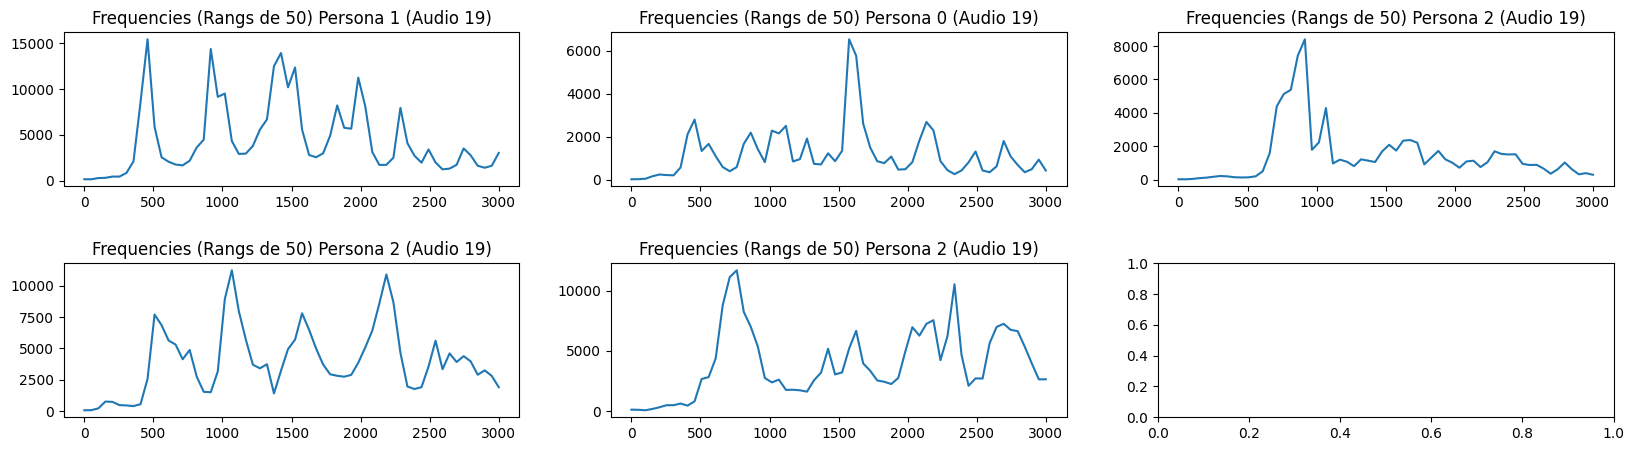

In [25]:
rangs = np.linspace(0.0, 3000, 60)
#yf = np.fft.fft(y)
#xf = np.linspace(0.0, 1.0/(2.0*T), int(n/2))
#ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))


nAudio = 19
audios = df[df['Id_Mensaje'] == nAudio]
audios = audios.reset_index()
fig, ax = plt.subplots(2, int(len(audios)/2) + 1, figsize=(20, 5))
i = 0
j = 0
for index, row in audios.iterrows():
      # Cargar el archivo de audio MP3
    try:
      y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
    except:
      y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
    
    yf = np.fft.fft(y)
    freq_ranges = slice_and_sum_frequencies(yf)
    ax[i, j].plot(rangs,freq_ranges)
    ax[i, j].set_title("Frequencies (Rangs de 50) Persona " + str(row['Id_Persona']) + " (Audio " + str(nAudio) +")")
    j = j + 1
    if j == int(len(audios)/2) + 1:
        j = 0
        i = i + 1
plt.subplots_adjust(hspace=0.5)



### Creación del dataset

In [26]:
matriu_freq = []


for index, row in df.iterrows(): # Cargar el archivo de audio MP3
    try:
      y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
    except:
      y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")

    yf = np.fft.fft(y)
    freq_ranges = slice_and_sum_frequencies(yf)
    matriu_freq.append(freq_ranges)

df_freq = df.copy()
for i in range(len(matriu_freq[0])):
    df_freq[f'freq_{i}'] = [matriu_freq[j][i] for j in range(len(matriu_freq))]


In [27]:
df_freq

,Id_Mensaje,Audio,Id_Persona,freq_0,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,...,freq_50,freq_51,freq_52,freq_53,freq_54,freq_55,freq_56,freq_57,freq_58,freq_59
0,1,01_Albert.mp3,1,122.458409,173.062650,201.698325,282.754727,3372.526762,4803.932755,4290.829377,...,307.413089,210.542841,127.162164,114.112105,119.731396,139.951297,101.946532,82.344157,85.420511,56.067277
1,1,01_Gerard.mp3,0,313.507616,335.930712,663.255525,8963.329673,6547.096135,1377.326550,3229.890973,...,1034.544351,652.520304,552.670001,816.885259,438.740671,331.222757,158.972787,268.555077,286.962154,121.260274
2,2,02_Albert.mp3,1,73.994145,205.073721,213.399783,249.459407,498.386437,3892.494693,1170.181432,...,1545.814370,812.314010,478.676389,579.298364,550.765186,372.782963,281.921728,253.041773,380.914890,197.626915
3,2,02_Gerard.mp3,0,177.836700,492.534333,1957.636136,5906.904584,3493.815963,1856.276730,3177.115113,...,627.747529,300.224257,453.866403,324.307449,258.070777,222.323931,237.140532,282.223410,234.290938,251.796791
4,3,03_Albert.mp3,1,171.892104,176.993115,214.829314,275.230486,302.913087,626.946722,1988.973923,...,177.338940,127.581931,120.639504,136.265273,118.843194,166.472038,112.438608,176.585398,107.968474,69.180967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,50,50_Albert.mp3,1,67.798741,251.967617,294.711164,342.909409,350.066383,384.702787,639.158247,...,2293.407598,1957.287931,1969.307711,1373.608176,1147.465841,921.084163,989.946019,920.563085,760.567279,1013.083915
163,50,50_Gerard.mp3,0,156.676307,164.954497,212.767367,345.836329,1392.133196,5165.992752,8013.514629,...,240.746455,469.251277,467.719373,326.283359,268.550752,223.574991,409.984373,504.675140,682.738964,728.918154
164,50,50_Jessi.mp3,2,27.186271,30.755463,71.015256,132.423754,188.513906,178.838507,111.394467,...,362.851450,350.635819,408.794584,559.330965,1025.930394,1661.318326,807.640036,856.986466,1055.687140,1220.505284
165,50,50_MadreGerard.mp3,2,116.535072,327.705519,1235.195829,2690.846620,3112.448346,2395.095549,2035.924739,...,3364.829341,3353.706088,4764.884410,2305.274688,1595.406098,1607.813847,1301.859666,1249.493286,949.769187,1102.447507


In [28]:
X = df_freq.drop(columns=['Id_Mensaje', 'Audio', 'Id_Persona'])
y = df_freq['Id_Persona']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((133, 60), (34, 60), (133,), (34,))

In [29]:
lr = LogisticRegression(max_iter=1000)
model = lr.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.40      0.40      0.40        10
           2       0.50      0.43      0.46        14

    accuracy                           0.50        34
   macro avg       0.49      0.51      0.50        34
weighted avg       0.50      0.50      0.49        34



### Comprovar cual es el rango optimo en el que separar las frequencias

Text(0, 0.5, 'Accuracy')

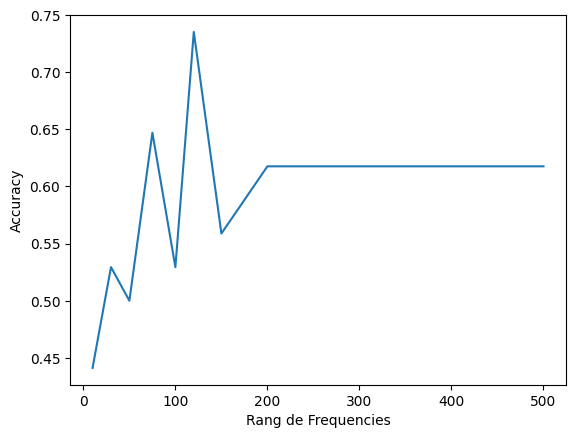

In [30]:
def backtest_rang(model='lr'):
  rangs = [10, 30, 50, 75, 100, 120, 150, 200, 300, 500]
  yfs = []
  accuracies = []
  reports = []

  for index, row in df.iterrows(): # Cargar el archivo de audio MP3
          try:
            y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
          except:
            y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")

          yfs.append(np.fft.fft(y))


  for rang in rangs:
      matriu_freq = []
      for yf in yfs:
          freq_ranges = slice_and_sum_frequencies(yf, rang)
          matriu_freq.append(freq_ranges)

      df_freq = df.copy()
      for i in range(len(matriu_freq[0])):
          df_freq[f'freq_{i}'] = [matriu_freq[j][i] for j in range(len(matriu_freq))]

      X = df_freq.drop(columns=['Id_Mensaje', 'Audio', 'Id_Persona'])
      y = df_freq['Id_Persona']
      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
      X_train.shape, X_test.shape, y_train.shape, y_test.shape
      
      if model == 'lr':
        m = LogisticRegression(max_iter=1000)

      elif model == 'rf':
        m = RandomForestClassifier()
        
      model = m.fit(X_train, y_train)
      y_pred = model.predict(X_test)

        
      accuracies.append(accuracy_score(y_test, y_pred))
      reports.append(classification_report(y_test, y_pred))
  return rangs, accuracies, reports
    
rangs, accuracies, reports = backtest_rang('lr')
plt.plot(rangs, accuracies)
plt.xlabel('Rang de Frequencies')
plt.ylabel('Accuracy')

In [31]:
millor_index = np.argmax(accuracies)
print("Millor rang de frequencies: ", rangs[millor_index])
print("---------------------------------")
print("---------------------------------")
print(reports[millor_index])

Millor rang de frequencies:  120
---------------------------------
---------------------------------
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       1.00      0.50      0.67        10
           2       0.77      0.71      0.74        14

    accuracy                           0.74        34
   macro avg       0.80      0.74      0.73        34
weighted avg       0.79      0.74      0.73        34



Millor rang de frequencies:  100
---------------------------------
---------------------------------
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       1.00      0.50      0.67        10
           2       0.63      0.86      0.73        14

    accuracy                           0.74        34
   macro avg       0.81      0.72      0.73        34
weighted avg       0.79      0.74      0.73        34



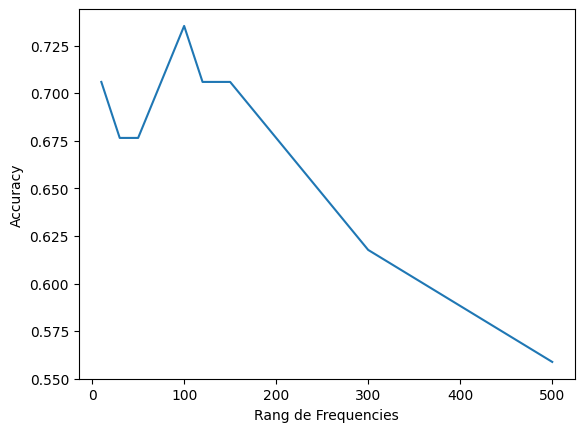

In [32]:
rangs, accuracies, reports = backtest_rang('rf')
plt.plot(rangs, accuracies)
plt.xlabel('Rang de Frequencies')
plt.ylabel('Accuracy')
millor_index = np.argmax(accuracies)
print("Millor rang de frequencies: ", rangs[millor_index])
print("---------------------------------")
print("---------------------------------")
print(reports[millor_index])

## Modelo mediante windowing o ventana deslizante para los espectogramas

In [33]:
def windowing(image, max_size):
    windows = np.zeros((max_size, image.shape[0]))  # Crear matriz de ventanas con el mismo número de columnas que la imagen
    for i in np.arange(0, image.shape[1]):
        windows[ i, :] = image[: , i]
    return windows


In [82]:
def compute_rowSpec(row, clean=False):
    try:
        y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
    except:
        y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
    
    #Treure silenci de l'inici i el final
    if clean:
        y = librosa.effects.trim(y)[0]
    
    image = wavelet_spec(y, sr)
    windows = windowing(image, 320)
    y = np.array([row['Id_Persona'] for i in range(320)])
    
    return windows, y


data = df.apply(lambda row: compute_rowSpec(row, True), axis=1)
data[0]

(array([[7.65854056e-05, 1.81965850e-04, 1.53222456e-04, ...,
         1.34156068e-07, 8.60522746e-08, 1.53817403e-08],
        [1.40367041e-03, 2.42877472e-03, 8.29046592e-04, ...,
         2.85198189e-06, 2.13081080e-06, 2.44288458e-07],
        [2.06381013e-03, 2.71291845e-03, 1.32333918e-03, ...,
         1.12492371e-05, 1.16978226e-05, 7.48837067e-07],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [155]:
X, y = zip(*data)

In [156]:
X = np.array(list(X))
y = np.array(list(y))



X.shape, y.shape

((167, 320, 128), (167, 320))

In [157]:
X = np.reshape(X, (X.shape[0] * X.shape[1], X.shape[2]))
y = np.reshape(y, (y.shape[0] * y.shape[1]))

In [158]:
X.shape, y.shape

((53440, 128), (53440,))

In [159]:
indices_0 = []

#Treure 0s
for i in range(len(X)):
    if np.mean(X[i]) == 0:
        indices_0.append(i)

new_X = []
new_y = []
for i in range(len(y)):
    if i not in indices_0:
        new_X.append(X[i])
        new_y.append(y[i])

X = np.array(new_X)
y = np.array(new_y)

print(X)

#Treure silenci (No se si ponerlo)
indices = []
half_mean_X = np.mean(np.mean(X, axis=1))/2
print(np.mean(X, axis=1))
print(half_mean_X)
for i in range(len(X)):
    if np.mean(X[i]) > half_mean_X:
        indices.append(i)
print(len(indices))
new_X = []
new_y = []
for i in indices:
    new_X.append(X[i])
    new_y.append(y[i])

X = np.array(new_X)
y = np.array(new_y)


[[7.65854056e-05 1.81965850e-04 1.53222456e-04 ... 1.34156068e-07
  8.60522746e-08 1.53817403e-08]
 [1.40367041e-03 2.42877472e-03 8.29046592e-04 ... 2.85198189e-06
  2.13081080e-06 2.44288458e-07]
 [2.06381013e-03 2.71291845e-03 1.32333918e-03 ... 1.12492371e-05
  1.16978226e-05 7.48837067e-07]
 ...
 [7.77431997e-03 2.20880229e-02 1.63493622e-02 ... 1.21087738e-04
  6.11997457e-05 3.33549860e-06]
 [1.69608146e-01 2.29110539e-01 2.61705190e-01 ... 9.74547642e-04
  8.37161439e-04 4.92647290e-04]
 [7.14675844e-01 8.33222508e-01 9.79117632e-01 ... 3.96205671e-03
  3.46938102e-03 2.10930197e-03]]
[5.48718899e-06 5.18528103e-05 1.78172685e-04 ... 1.40659960e+01
 1.62202642e+01 8.53233669e+00]
1.4875636146737163
3896


In [160]:
X.shape, y.shape

((3896, 128), (3896,))

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3116, 128), (780, 128), (3116,), (780,))

In [90]:
num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(128,)),  # Capa densa con 64 neuronas
    layers.Dense(32, activation='relu'),                      # Capa densa con 32 neuronas
    layers.Dense(num_classes, activation='softmax')            # Capa de salida con activación softmax
])
model.compile(optimizer= 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model

model.fit(X_train, y_train, epochs=400, batch_size=1024, validation_data=(X_test, y_test))




Epoch 1/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3743 - loss: 1.0979 - val_accuracy: 0.3859 - val_loss: 1.0959
Epoch 2/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3838 - loss: 1.0955 - val_accuracy: 0.3859 - val_loss: 1.0942
Epoch 3/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3877 - loss: 1.0938 - val_accuracy: 0.3859 - val_loss: 1.0933
Epoch 4/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3843 - loss: 1.0933 - val_accuracy: 0.3859 - val_loss: 1.0928
Epoch 5/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3829 - loss: 1.0931 - val_accuracy: 0.3859 - val_loss: 1.0925
Epoch 6/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3828 - loss: 1.0931 - val_accuracy: 0.3859 - val_loss: 1.0924
Epoch 7/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3850 - loss: 1.0925 - val_accuracy: 0.3859 - val_loss: 1.0924
Epoch 8/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3872 - loss: 1.0921 - val_accuracy: 0.3859 - v

In [162]:
rf = RandomForestClassifier()   

model = rf.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       185
           1       0.96      0.88      0.92       225
           2       0.93      0.98      0.95       370

    accuracy                           0.95       780
   macro avg       0.96      0.95      0.96       780
weighted avg       0.95      0.95      0.95       780

